<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S14/S14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libs

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
from PIL import Image
import numpy as np
import zipfile
from glob import glob
from fastprogress import progress_bar,master_bar
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm_notebook
import gc
import shutil

In [0]:
bg_datapath = '/content/gdrive/My Drive/Depth/S14'
fg_datapath = '/content/gdrive/My Drive/Depth/fg_images'

## Dense Model

In [0]:
!git clone https://github.com/ialhashim/DenseDepth.git


Cloning into 'DenseDepth'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 11.80 MiB | 32.73 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5


--2020-05-10 15:40:59--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.59
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  31.2MB/s    in 6.0s    

2020-05-10 15:41:05 (27.6 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



In [0]:
from DenseDepth.layers import *
from keras.models import load_model
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [0]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}


In [0]:
model = load_model('./DenseDepth/nyu.h5', custom_objects=custom_objects, compile=False)


## Try Depth Model and try out the steps on one image


In [0]:
all_bg_images = glob(bg_datapath+'/*.jpg')+glob(bg_datapath+'/*.png')+glob(bg_datapath+'/*.jpeg')

In [0]:
all_fg_images = glob(fg_datapath+'/*.png')

In [0]:
len(all_fg_images)

100

In [0]:
for f in all_fg_images:
  s = np.array(Image.open(f)).shape
  #print(len(s))
  if len(s)<3:
    print(f)
  elif s[2]<4:
    print(f)

In [0]:
bg_img= Image.open(all_bg_images[-6]).resize((640,480))

In [0]:
fg_img=Image.open(all_fg_images[-2]).resize((int(0.7*640),int(0.7*480)))

In [0]:
fg_img=Image.open('/content/gdrive/My Drive/Depth/fg_images/img98_fg.png')

In [0]:
fg_img=fg_img.resize((int(0.7*640),int(0.7*480)))

In [0]:
bg_img.paste(fg_img,(0,0),fg_img)

In [0]:
bg_img = bg_img.resize((480,480))

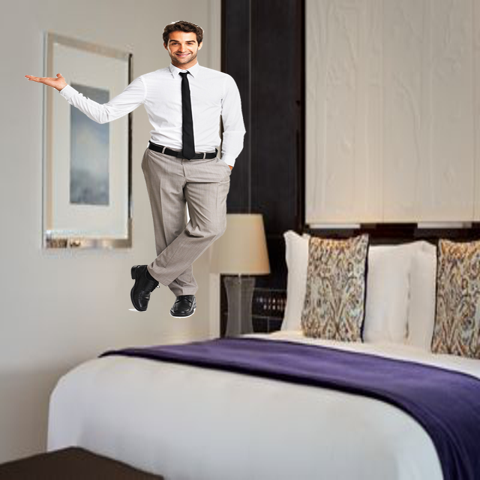

In [0]:
bg_img

In [0]:
imgt=model.predict(np.array(bg_img)[None,...])

In [0]:
%%timeit
imgt=model.predict(np.stack([np.array(bg_img)]*100),batch_size=60)

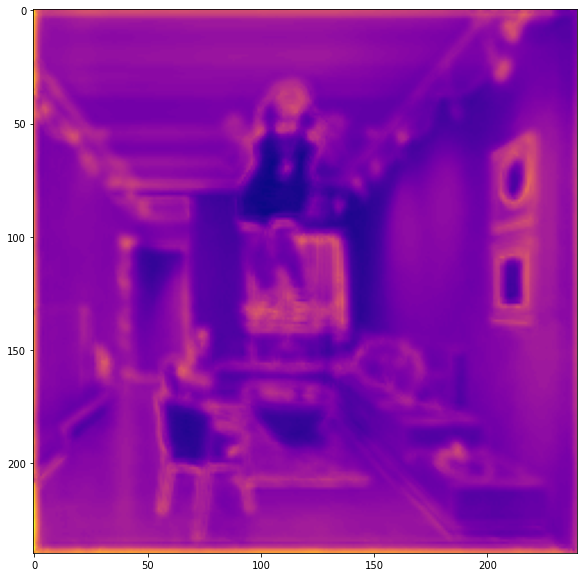

In [0]:
viz = display_images(imgt[:1].astype('uint8'))
plt.figure(figsize=(10,10))
plt.imshow(viz)
plt.savefig('test.png')
plt.show()

In [0]:
imgs=np.array([np.array(i) for i in imgs])

In [0]:
imgs[0].shape

(224, 224, 3)

In [0]:
outputs = predict(model, np.array(imgs))


## Create the Dataset 

In [0]:
!rm images.zip

In [0]:
allimgs = zipfile.ZipFile('images.zip',mode='a',compression=zipfile.ZIP_STORED)
info_dict=defaultdict(lambda:[])
initial_size = (480,480)
final_size = (240,240)
batch=[]
batch_names=[]
bs=50
mb = master_bar(all_bg_images[:])
for bidx,bg in enumerate(mb,start=1):
  for fidx,fg in enumerate(progress_bar(all_fg_images[:],parent=mb),start=1):
    # read foregorund image and clip its size to between 70% and 50% of intial size
    fg_img = Image.open(fg)
    fg_w,fg_h = fg_img.size
    # resize the foregorund to 240
    fg_img=fg_img.resize((240,240))
    # read the background image and resize it to 480
    bg_img = Image.open(bg).resize(initial_size)
    bg_img = Image.fromarray(np.array(bg_img)[...,:3])
    # get the width and height for background image
    bg_width,bg_height = bg_img.size
    # get the width and height for foreground image
    fg_width,fg_height = fg_img.size
    # extract the mask from the foreground image as the 4th channel
    fg_mask = Image.fromarray(np.array(fg_img)[...,3])
    savename_bg = f'bg_bidx_{bidx}.jpg'
    save_bg = bg_img.resize(final_size)
    save_bg.save('save_bg.jpg')
    allimgs.write('save_bg.jpg',f'bg_images/{savename_bg}')
    count = 0 
    # get random 20 positions for every background and foreground image
    for i in range(1,21):
      for flipidx in range(2):
        count+=1
        # get random offset for pasting 
        width_offset,height_offset = np.random.randint(-20,bg_width-fg_width),np.random.randint(-20,bg_height-fg_height)
        # paste the foreground on background 
        temp_bg = bg_img.copy()
        temp_mask = Image.new('L',temp_bg.size)
        if flipidx>0:
          savename_bg_fg = f'bg_fg_flipped_bidx_{bidx}_fidx_{fidx}_random_{i}.jpg'
          savename_mask = f'bg_mask_flipped_bidx_{bidx}_fidx_{fidx}_random_{i}.jpg'
          savename_depth = f'bg_depth_flipped_bidx_{bidx}_fidx_{fidx}_random_{i}.npy'
          temp_fg = fg_img.transpose(Image.FLIP_LEFT_RIGHT)
          temp_fg_mask = fg_mask.transpose(Image.FLIP_LEFT_RIGHT)
        else:
          savename_bg_fg = f'bg_fg_bidx_{bidx}_fidx_{fidx}_random_{i}.jpg'
          savename_mask = f'bg_mask_bidx_{bidx}_fidx_{fidx}_random_{i}.jpg'
          savename_depth= f'bg_depth_bidx_{bidx}_fidx_{fidx}_random_{i}.npy'
          temp_fg = fg_img
          temp_fg_mask = fg_mask

        temp_bg.paste(temp_fg,(width_offset,height_offset),fg_img)
        temp_mask.paste(temp_fg_mask,(width_offset,height_offset),fg_mask)
        batch_names.append(savename_depth)
        batch.append(temp_bg)
        if len(batch)==2000:
          batch = np.stack(batch)
          batch_output = model.predict(batch,batch_size=bs).astype('uint8')
          for di,n in enumerate(batch_names):
            ts = batch_output[di].shape
            if ts[0]<240:
              raise RuntimeError("Some problem in prediction")
            np.save('temp_depth.npy', batch_output[di])
            allimgs.write('temp_depth.npy',f'bg_fg_depth_images/{n}')
            info_dict['depth_images'].append(n)
          del batch,batch_names
          gc.collect()
          batch=[]
          batch_names=[]
        temp_bg = temp_bg.resize(final_size)
        temp_mask = temp_mask.resize(final_size)
        temp_bg.save('temp_bg.jpg')
        temp_mask.save('temp_mask.jpg')
        allimgs.write('temp_bg.jpg',f'bg_fg_images/{savename_bg_fg}')
        allimgs.write('temp_mask.jpg',f'bg_masks/{savename_mask}')
        info_dict['bg_images'].append(savename_bg)
        info_dict['bg_fg_images'].append(savename_bg_fg)
        info_dict['fg_masks'].append(savename_mask)
        info_dict['bg_names'].append(bg)
        info_dict['fg_names'].append(fg)
        info_dict['flipped'].append(False if flipidx==0 else True)
        info_dict['random_number'].append(i)
  if bidx%10==0:
    # move the zip file to gdrive
    print(f"Moving the zip file to google drive now after bg index{bidx}.....")
    allimgs.close()
    shutil.move('images.zip',f'/content/gdrive/My Drive/Depth/images_{bidx}.zip')
    info_df = pd.DataFrame(info_dict)
    info_df.to_csv('image_info.csv',index=False)
    shutil.move('image_info.csv',f'/content/gdrive/My Drive/Depth/image_info_{bidx}.csv')
    allimgs = zipfile.ZipFile('images.zip',mode='a',compression=zipfile.ZIP_STORED)
    del info_dict
    gc.collect()
    info_dict=defaultdict(lambda:[])



/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_1.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_2.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_3.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_4.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_5.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_6.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_7.jp

Moving the zip file to google drive now after bg index10.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_11.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_12.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_13.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_14.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_15.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_16.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index20.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_21.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_22.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_23.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_24.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_25.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_26.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index30.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_31.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_32.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_33.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_34.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_35.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_36.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index40.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_41.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_42.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_43.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_44.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_45.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_46.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index50.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_51.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_52.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_53.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_54.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_55.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_56.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index60.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_61.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_62.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_63.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_64.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_65.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_66.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid

Moving the zip file to google drive now after bg index70.....


/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_71.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_72.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_73.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_74.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_75.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bidx_76.jpg'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.6/zipfile.py:1378: UserWarning: Duplicate name: 'bg_images/bg_bid